# Построение модели для прогнозирования прочности при растяжении

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data_model.csv', index_col = 0)
df.sample(3)

,T1,F1,F2,F3,F4,F5,F6,T2,T3,F7,F9,F10
70.0,3.725152,2009.398720,962.774186,148.316386,16.869670,289.236170,398.919838,69.204642,1337.424692,172.549269,5.182935,79.514070
504.0,2.701485,1898.262943,927.375048,78.735765,25.573778,362.651759,218.819077,74.236660,1991.478742,313.192730,5.267143,37.950852
915.0,4.529072,1816.400606,428.924382,138.348410,24.757775,233.724615,530.591317,76.823842,2973.053247,132.550916,6.096099,58.572282


In [3]:
df.columns

Index(['T1', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'T2', 'T3', 'F7', 'F9',
       'F10'],
      dtype='object')

In [4]:
df_1 = df.drop(['F1', 'F2', 'F3', 'F4', 'F5', 
                'F6', 'T2', 'F7', 'F9','F10'], axis = 1)
df_1.head(5)

,T1,T3
1.0,1.857143,3000.0
3.0,1.857143,3000.0
4.0,2.771331,3000.0
5.0,2.767918,3000.0
6.0,2.569620,3000.0


Наименьшее абсолютное отклонение\
Модель LAD представляет собой частный случай квантильной регрессии, где q = 0,5.

In [7]:
mod = smf.quantreg("T3 ~ T1", df_1)
res = mod.fit(q=0.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                     T3   Pseudo R-squared:            0.0001196
Model:                       QuantReg   Bandwidth:                       231.3
Method:                 Least Squares   Sparsity:                        1147.
Date:                Wed, 27 Apr 2022   No. Observations:                  936
Time:                        13:40:04   Df Residuals:                      934
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2437.4997     64.186     37.976      0.000    2311.534    2563.465
T1             7.7488     20.983      0.369      0.712     -33.430      48.927


Мы оцениваем модель квантильной регрессии для многих квантилей между 0,05 и 0,95 и сравниваем линию наилучшего соответствия каждой из этих моделей с результатами обычного метода наименьших квадратов.

Для удобства мы помещаем результаты квантильной регрессии в Pandas DataFrame, а результаты OLS — в словарь.

In [9]:
quantiles = np.arange(0.05, 0.95, 0.1)


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], 
            res.params["T1"]] + res.conf_int().loc["T1"].tolist()


models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])

ols = smf.ols("T3 ~ T1", df_1).fit()
ols_ci = ols.conf_int().loc["T1"].tolist()
ols = dict(a=ols.params["Intercept"], b=ols.params["T1"], lb=ols_ci[0], ub=ols_ci[1])

print(models)
print(ols)

      q            a          b         lb          ub
0  0.05  1644.760385  25.574498 -35.953734   87.102731
1  0.15  1986.333447   1.904618 -44.320597   48.129832
2  0.25  2126.819265   6.798497 -40.782047   54.379041
3  0.35  2334.529713 -15.262659 -59.761718   29.236400
4  0.45  2392.061413   8.592336 -33.046746   50.231418
5  0.55  2450.938625  21.634130 -18.688677   61.956936
6  0.65  2571.407114  22.878818 -19.702692   65.460328
7  0.75  2730.402787  12.377234 -33.597809   58.352277
8  0.85  2726.093894  76.555928  31.431278  121.680577
{'a': 2430.3049592646444, 'b': 12.709462335815088, 'lb': -20.60841612986198, 'ub': 46.02734080149216}


Далее сравниваются линии наилучшего соответствия для 10 моделей квантильной регрессии с подбором методом наименьших квадратов. 
Оценки методом наименьших квадратов довольно плохо соответствуют наблюдениям за соотношением.

Text(0, 0.5, 'Прочность')

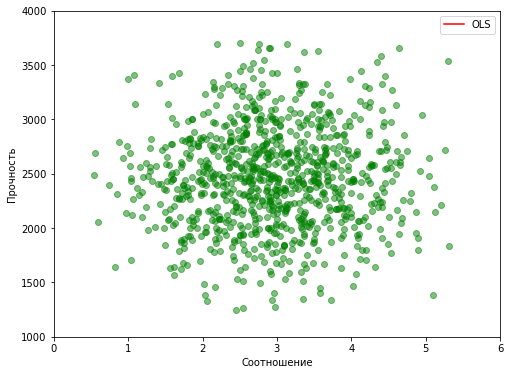

In [10]:
x = np.arange(df_1.T1.min(), df_1.T1.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle="dotted", color="grey")

y = get_y(ols["a"], ols["b"])

ax.plot(x, y, color="red", label="OLS")

ax.scatter(df.T1, df.T3, alpha=0.5, color = "green")
ax.set_xlim((0, 6))
ax.set_ylim((1000, 4000))
legend = ax.legend()
ax.set_xlabel("Соотношение", fontsize=10)
ax.set_ylabel("Прочность", fontsize=10)

Черные пунктирные линии образуют точечный доверительный интервал 95% вокруг 10 оценок квантильной регрессии (сплошная черная линия). Красные линии представляют результаты регрессии МНК вместе с их 95% доверительным интервалом.

В большинстве случаев оценки точек квантильной регрессии лежат за пределами доверительного интервала МНК.

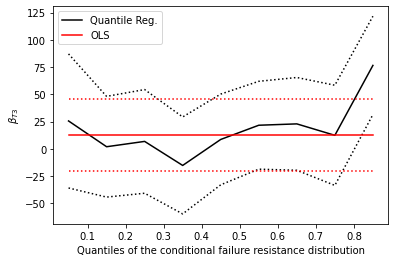

In [11]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color="black", label="Quantile Reg.")
p2 = plt.plot(models.q, models.ub, linestyle="dotted", color="black")
p3 = plt.plot(models.q, models.lb, linestyle="dotted", color="black")
p4 = plt.plot(models.q, [ols["b"]] * n, color="red", label="OLS")
p5 = plt.plot(models.q, [ols["lb"]] * n, linestyle="dotted", color="red")
p6 = plt.plot(models.q, [ols["ub"]] * n, linestyle="dotted", color="red")
plt.ylabel(r"$\beta_{T3}$")
plt.xlabel("Quantiles of the conditional failure resistance distribution")
plt.legend()
plt.show()